In this set of notebooks, I will be exploring model interpretation. I will be using the CT images from the RICORD Database, which is for COVID-19 diagnoses. The images are in DICOM format. Set 1a is the positive diagnoses and set 1b is the negative diagnoses. 
This notebook will first explore the data set marginally, and then convert the DICOM images to PNGs

dataset 1a https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=80969742

dataset 1b https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=80969771

In [1]:
#to display and save the images
import matplotlib.pyplot as plt
import numpy as np

import os
import cv2

import tensorflow as tf
from tensorflow import keras

#to read the dicom images
import pydicom


In [2]:
neg_dir='D:\\tensorflow_datasets\\covid-CT\\negative\\manifest-1612365584013\\MIDRC-RICORD-1B'
pos_dir='D:\\tensorflow_datasets\\covid-CT\positive\\manifest-1608266677008\\MIDRC-RICORD-1A'

# Get the list of all files in directory tree at given path
def buildList(directoryPath):
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(directoryPath):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    return listOfFiles

In [3]:
negative_files = buildList(neg_dir)
positive_files = buildList(pos_dir)

Let's go ahead and get some metrics for our data. We can see that there are approximately 50% more positive cases than negative, so we have some class imbalance. However, we will be sampling our training and test datasets from these. So, we can sample our training set to have an even balance. 

In [4]:
print('negative file example: ', negative_files[0])
print('positive file example: ', positive_files[0])
print('\n')
print('# of negative results: ', len(negative_files))
print('# of positive results: ', len(positive_files))
print('total images: ', len(negative_files)+len(positive_files))

print('positive:negative ratio: ', len(positive_files)/len(negative_files))

negative file example:  D:\tensorflow_datasets\covid-CT\negative\manifest-1612365584013\MIDRC-RICORD-1B\MIDRC-RICORD-1B-419639-000340\01-18-2005-NA-CT CHEST HIGH RESOLUTION-06379\2.000000-SUPINE CHEST RECON 12-09859\1-001.dcm
positive file example:  D:\tensorflow_datasets\covid-CT\positive\manifest-1608266677008\MIDRC-RICORD-1A\MIDRC-RICORD-1A-419639-000082\08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614\1.000000-SCOUT CHEST-97846\1-1.dcm


# of negative results:  21220
# of positive results:  31856
total images:  53076
positive:negative ratio:  1.501225259189444


Now let's read a single DICOM image to test, and output the image array that we will be using. We aren't going to be using the other info attached to the dicom images - we only want the images themselves. We can use pydicom to read the images, and with numpy installed we can convert the pixel array to an ndarray

image size:  (512, 512)


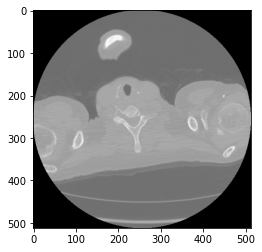

array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16)

In [5]:
ds=pydicom.dcmread(negative_files[0])
arr = ds.pixel_array

#print the size of the image(s)
print('image size: ', arr.shape)
#plot our image - these are grayscale
plt.imshow(arr, cmap="gray")
plt.show()
#print our array
arr

There are a few orientations for ct images. Supine, as shown above, involves the patient laying on their back, with head and feet aligned in the z-axis (center of image). Prone is similar, but the patient is lying on their stomach. While it might not be clear in some images, we should be able to see to large cavities, which are the lungs, and one small cavity, which is the trachea. If the traches is towards the top of the image, then we know the patient is prone. If it's towards the bottom, then we know they are supine. There are also upright CTs with the patients facing either forward (towards the camera,viewer), or to the side. 

As seen below, we can halve the image size without losing too much quality. To speed things up (since my computer is slow), we might even halve them again. 

Text(0.5, 1.0, 'Quarter Size')

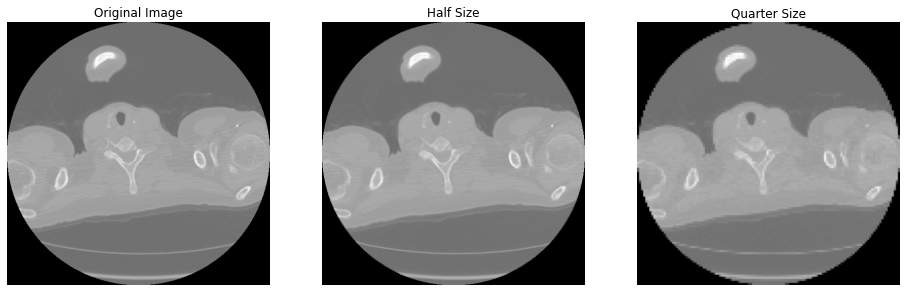

In [6]:
plt.figure(figsize=(16, 5))

ax = plt.subplot(1, 3, 1)
plt.imshow(arr, cmap="gray")
plt.axis('off')
plt.title('Original Image')

ax = plt.subplot(1, 3, 2)
arr_resize = cv2.resize(arr,(256,256))
plt.imshow(arr_resize, cmap="gray")
plt.axis('off')
plt.title('Half Size')

ax = plt.subplot(1, 3, 3)
arr_resize = cv2.resize(arr,(128,128))
plt.imshow(arr_resize, cmap="gray")
plt.axis('off')
plt.title('Quarter Size')

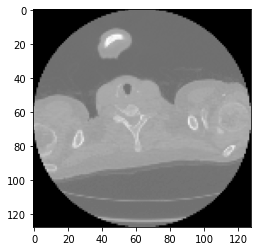

In [7]:
#currently not using this
arr_resize.reshape(-1,128,128,1)
plt.imshow(arr_resize, cmap="gray")


Now we can write a function to convert the DICOM images to PNG images for easier processing

For now, we will write images at quarter size for time consideration.

In [8]:
negative_outdir= 'D:\\tensorflow_datasets\\covid-CT\\negative\\images'
positive_outdir ='D:\\tensorflow_datasets\\covid-CT\\positive\\images'


def writeImages(fileList, outDir, img_size):
    i=0
    for x in fileList: 
        ds=pydicom.dcmread(x,force=False).pixel_array
        ds=cv2.resize(ds,(img_size,img_size))
        plt.imsave(os.path.join(outDir,'img'+str(i)+'.png'),ds,cmap='gray')
        i+=1

In [10]:
img_size=128
#write our positive images

# uncomment the following line to convert all the positive test result DICOM images to PNG
#writeImages(positive_files,positive_outdir,img_size)

In [ ]:
# Uncomment the following line to run function to convert all the negative test result DICOM images
#writeImages(negative_files,negative_outdir,img_size)

Now we can move on to training a model and implementing intrepretation (gradCam)